# E-Commerce Customer Segmentation Analysis (RFM & K-Means)

## Objective

Customer segmentation is crucial as it enables e-commerce businesses to customize marketing strategies for different customer groups, which also helps optimize marketing costs.

The purpose of this analysis is to segment customers based on their purchase behaviors, including recency, frequency, and monetary aspects. I will utilize both RFM and K-Means clustering techniques in this study, with the aim of comparing these two methods. 

## Key Takeaways

 - RFM Segmentation divides customers into 5 groups, including "Champion", "Need Attention", "Potential Big Spender", "Promising" and "Low Value".
 - K-Means clustering divides customers into 4 clusters.
 - RFM Segmentation offers more meaningful insights for optimizing marketing strategies compared to K-Means.

### PART 1. RFM Segmentation

Import the RFM data from MySQL. (MySQL code: github.com)

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv("rfm_raw_sql.csv", sep=';')
df.head()

,Customer_id,Recency,Frequency,Monetary
0,2aa9325eab1676f4d62830f004d67a34,278,1,12.77
1,bb50112c998293f45f49f49704165768,526,1,18.90
2,ebf40c0db4fe06ddd15a7a44238c986e,141,2,197.35
3,56987d3e10c71d7d4e0fc479e65a35b6,69,1,246.90
4,3159faae98c743546432be5a500179a1,513,1,14.00


Examine the structure and content of the dataset.

In [203]:
print("DATASET OVERVIEW: \n")
print(df.info())
print("\n")
print("STATISTICAL SUMMARY: \n")
print(df.describe())

DATASET OVERVIEW: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94990 entries, 0 to 94989
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer_id  94990 non-null  object 
 1   Recency      94990 non-null  int64  
 2   Frequency    94990 non-null  int64  
 3   Monetary     94990 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.9+ MB
None


STATISTICAL SUMMARY: 

            Recency     Frequency      Monetary
count  94990.000000  94990.000000  94990.000000
mean     301.305253      1.035119    142.061277
std      153.002379      0.215342    216.070479
min       15.000000      1.000000      0.000000
25%      177.000000      1.000000     47.882500
50%      282.000000      1.000000     89.810000
75%      410.000000      1.000000    155.000000
max      787.000000     17.000000  13440.000000


There are a total of 94,990 unique customers with valid purchased orders (orders marked as "canceled" or "unavailable" were filtered out in SQL).

Below is the visualization showing the distribution of Recency, Frequency and Monetary:

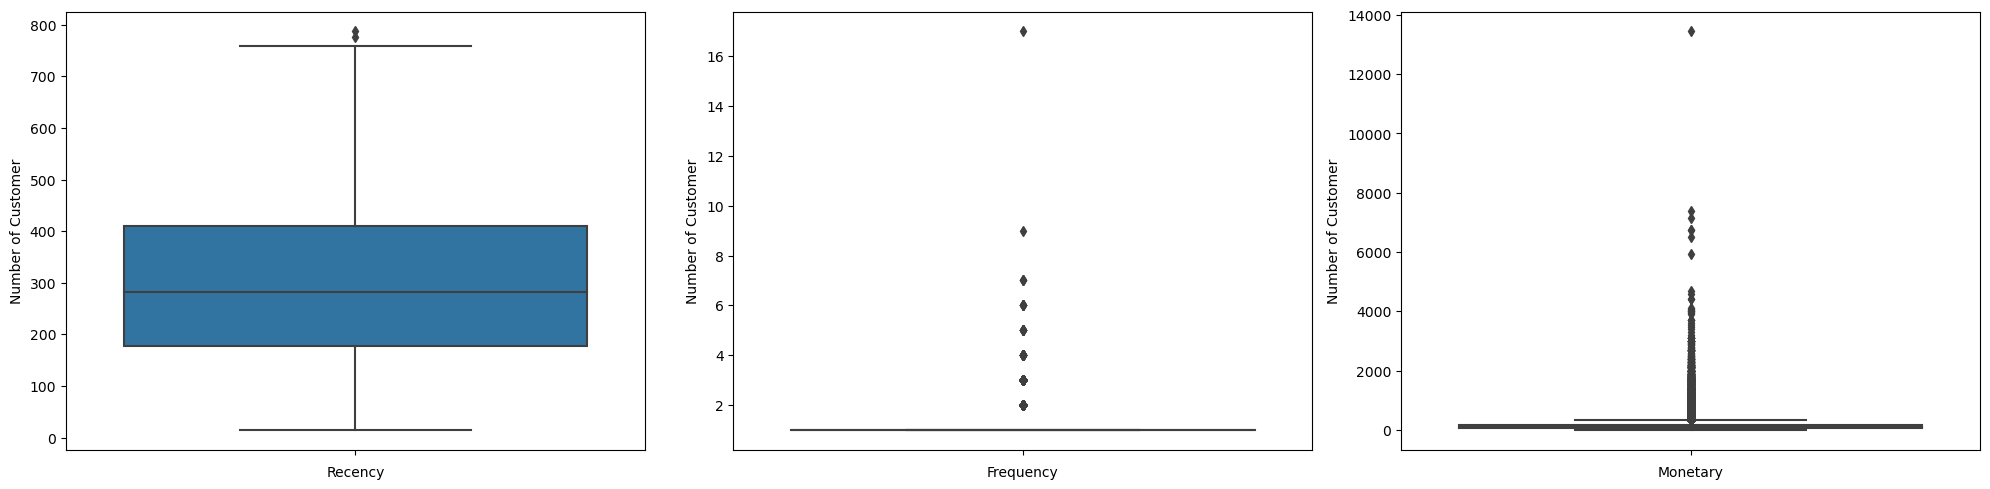

In [204]:
#Distribution of Recency, Frequency, Monetary
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, feature in enumerate(df.columns[1:4]):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Number of Customer')

plt.tight_layout()
plt.show()

Summary of Distribution:

- Recency: The majority of orders were made between 200 and 400 days ago, while the most recent orders were placed within the last 3 months.

- Frequency: Most customers are one-time buyers, with a few purchasing less than 10 times. There is an outlier customer who made 17 purchases.

- Monetary: The majority of customers have spent less than 200 dollars in total. The highest transaction value recorded is 13,440 dollars, as shown in the statistical summary. 

Now, assign RFM scores based on the distribution. 

In this analysis, I'm using a scale of Tiers 1 - 4, with Tier 1 representing the best performance and Tier 4 representing the least favorable performance.

In [205]:
## Create a new dataset for the analysis to avoid modifing the original one.
df_rfm = df.copy()

In [207]:
## Recency Score
def R_Score(r):
    if r < np.percentile(df_rfm.Recency,25):
        return 1
    elif r < np.percentile(df_rfm.Recency,50):
        return 2
    elif r < np.percentile(df_rfm.Recency,75):
        return 3
    else:
        return 4
df_rfm["R"] = df_rfm.Recency.apply(R_Score)

As for "Frequency" score, given that most customers have only made one purchase in this dataset, as indicated by the previous boxplot, I suspected that the percentile method might not be suitable for defining the frequency level. To validate it, I examined the detailed distribution of frequency:

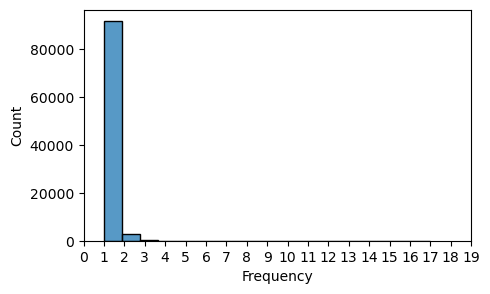

           Number of Customers Percentage
Frequency                                
1                        92001     96.85%
2                         2738      2.88%
3                          202      0.21%
4                           30      0.03%
5                            8      0.01%
6                            6      0.01%
7                            3      0.00%
9                            1      0.00%
17                           1      0.00%


In [208]:
## Frequency Distribution
plt.figure(figsize = (5,3))
sns.histplot(df_rfm['Frequency'])
plt.xticks(range(0,20))
value_counts = df_rfm['Frequency'].value_counts().sort_index()
percentage = (value_counts/total_value)*100
percentage = percentage.apply(lambda x: '{:.2f}%'.format(x))
freq_sum = pd.concat([value_counts, percentage], axis = 1)
freq_sum.columns = ["Number of Customers", "Percentage"]
freq_sum.index.name = 'Frequency'
plt.show()
print(freq_sum)

Considering that 97% of our customers are one-time buyers, utilizing percentiles to assign Frequency scores wouldn't be appropriate, as all percentiles correspond to value "1".

In this case, the F_score will be assign as follow: 

    Tier 1 for the most frequently purchased buyers, 
    Tier 2 for buyers with 5-9 purchased orders, 
    Tier 3 for buyers with 2-4 purchased orders,
    Tier 4 for one-time buyers.

In [209]:
## Frequency
def F_Score(f):
    if f > 7:
        return 1
    elif f > 4:
        return 2
    elif f > 1:
        return 3
    else:
        return 4
df_rfm["F"] = df_rfm.Frequency.apply(F_Score)

In [210]:
## Monetary
def M_Score(m):
    if m > np.percentile(df_rfm.Monetary,75):
        return 1
    elif m > np.percentile(df_rfm.Monetary,50):
        return 2
    elif m > np.percentile(df_rfm.Monetary,25):
        return 3
    else:
        return 4
df_rfm["M"] = df_rfm.Monetary.apply(M_Score)

After assigning scores to customers based on their recency, frequency, and monetary levels, the RFM score can be generated by synthesizing these three individual scores. 

In [211]:
def RFM(x):
    return str(x['R']) + str(x['F']) + str(x['M'])
df_rfm['RFM'] = df_rfm.apply(RFM,axis=1)

In [212]:
df_rfm.head()

,Customer_id,Recency,Frequency,Monetary,R,F,M,RFM
0,2aa9325eab1676f4d62830f004d67a34,278,1,12.77,2,4,4,244
1,bb50112c998293f45f49f49704165768,526,1,18.90,4,4,4,444
2,ebf40c0db4fe06ddd15a7a44238c986e,141,2,197.35,1,3,1,131
3,56987d3e10c71d7d4e0fc479e65a35b6,69,1,246.90,1,4,1,141
4,3159faae98c743546432be5a500179a1,513,1,14.00,4,4,4,444


Next, segment different customer groups based on their RFM scores. 

In [213]:
print(df_rfm["RFM"].nunique())
print(df_rfm["RFM"].unique())

38
['244' '444' '131' '141' '344' '332' '121' '441' '341' '142' '144' '343'
 '331' '442' '243' '342' '242' '143' '241' '231' '334' '443' '431' '233'
 '133' '433' '232' '132' '333' '234' '434' '432' '134' '221' '211' '111'
 '321' '423']


There are 38 distinct RFM scores in the dataset, which are divided into 5 segments:

    CHAMPION 
    (best customers): 111
    
    POTENTIAL BIG SPENDER 
    (big spender who purchased recently): 
    131, 141, 142, 321, 242, 241, 231, 232, 132, 121, 221, 211
    
    NEED ATTENTION 
    (big spender who didn't return or frequently purchase): 
    441,341,331, 431 
    
    PROMISING 
    (new recent customer with low spending): 
    244, 144, 243, 143, 233, 133, 134, 234
    
    LOW VALUE 
    (low in RFM): 
    332, 442, 342, 432, 423, 444, 344, 343, 334, 443, 433, 333, 434

In [214]:
segment = [0]*len(df_rfm)

for i in range(0,len(df_rfm)):
    if df_rfm['RFM'][i]=='111':
        segment[i]='CHAMPION'
    elif df_rfm['RFM'][i] in ["131", "141", "142", "321", "242", "241", "231", "232", "132", "121", "221", "211"]:
        segment[i]='POTENTIAL BIG SPENDER'
    elif df_rfm['RFM'][i] in ["441","341","331","431"]:
        segment[i]='NEED ATTENTION'
    elif df_rfm['RFM'][i] in ["244", "144", "243", "143", "233", "133", "134", "234"]:
        segment[i]='PROMISING '
    else:
        segment[i]='LOW VALUE'

df_rfm["Segment"] = segment
df_rfm.head()

,Customer_id,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,2aa9325eab1676f4d62830f004d67a34,278,1,12.77,2,4,4,244,PROMISING
1,bb50112c998293f45f49f49704165768,526,1,18.90,4,4,4,444,LOW VALUE
2,ebf40c0db4fe06ddd15a7a44238c986e,141,2,197.35,1,3,1,131,POTENTIAL BIG SPENDER
3,56987d3e10c71d7d4e0fc479e65a35b6,69,1,246.90,1,4,1,141,POTENTIAL BIG SPENDER
4,3159faae98c743546432be5a500179a1,513,1,14.00,4,4,4,444,LOW VALUE


Here is a brief summary of the RFM segmentation results:

In [330]:
Segment_sum = df_rfm.groupby("Segment").agg({"Recency": "mean", "Frequency": "mean", 
                                               "Monetary":"mean"})
Segment_sum["Segment Size"] = df_rfm.groupby("Segment").size()
priority = ["CHAMPION", "NEED ATTENTION", "POTENTIAL BIG SPENDER", "PROMISING", "LOW VALUE"]
Segment_sum

,Recency,Frequency,Monetary,Segment Size
Segment,,,,
CHAMPION,72.000000,17.000000,729.620000,1
LOW VALUE,426.878041,1.017538,70.182753,35807
NEED ATTENTION,428.472894,1.069218,356.470690,11861
POTENTIAL BIG SPENDER,174.667238,1.066276,236.109849,23915
PROMISING,174.160813,1.012219,47.251618,23406


Summary of RFM Segmentation Result:


- Champion: This segment is characterized by the highest Frequency and Monetary, along with the most recent purchases. Although there's only one customer who belongs to this group in this dataset, it is crucial to differentiate them due to their exceptional value to the business. For champions, offering special promotional codes or sending emails with information about the latest products can help maintain a strong relationship. As the biggest supporters, encouraging them to share positive reviews and enroll in the loyalty program will help boost the business. Additionally, it's essential to closely monitor their behaviors, including reviews, frequently purchased items, and promptly addressing their needs.


- Need Attention: This segment of customers has spent above the average but has been inactive for a long while. It would be a loss for business to lose them permanently. In addition to sending reminder emails, it is also crucial to analyze their previous purchase journey to identify any potential issues that might be causing their disengagement.


- Potential big spender: This group comprises over 23,000 customers, representing approximately 20% of the total. While they may not have spent as much as the "Need Attention" group, they have still exceeded the average spending level. What sets them apart is that they are recent customers who made purchases within the last 6 months. To encourage these customers to continue spending, consider sending them notifications for discounts or bundle purchase offers.


- Promising: This group shares a similar customer size and recency with the "Potential Big Spender" segment, but their spending is much lower. This could be attributed to budget constraints, or it could be coincidental that they bought lower-cost items during their initial purchases. However, they still have the potential to become big spenders in the future. To engage this customer group, sending discount emails based on their past purchases or newsletters highlighting popular products across various categories could motivate them to revisit the website. 


- Low value: This segment comprises customers with the lowest average frequency and monetary value, and they have been inactive for a long period. If the marketing budget is limited, considering removing this group from the marketing list might be a viable option. This group comprises the largest number of customers, suggesting a potential loss of customers for the business. While this scenario is typical for many new businesses (Olist was founded in 2015, and the earliest record in this dataset is from 2016), it still warrants attention and further investigation to uncover the underlying issues.

reference: https://www.analyticsvidhya.com/blog/2021/07/customer-segmentation-using-rfm-analysis/;
           https://medium.com/analytics-vidhya/kmeans-clustering-on-rfm-t-segmentation-with-python-for-online-retail-data-ad9a2a7ab59

### PART 2. K-Means Segmentation

In [331]:
df_kmean = df.copy()

In [332]:
## Create a new dataset for the analysis to avoid modifing the original one.
df_kmean.head()

,Customer_id,Recency,Frequency,Monetary
0,2aa9325eab1676f4d62830f004d67a34,278,1,12.77
1,bb50112c998293f45f49f49704165768,526,1,18.90
2,ebf40c0db4fe06ddd15a7a44238c986e,141,2,197.35
3,56987d3e10c71d7d4e0fc479e65a35b6,69,1,246.90
4,3159faae98c743546432be5a500179a1,513,1,14.00


Determine the optimal number of clusters using the Elbow method:

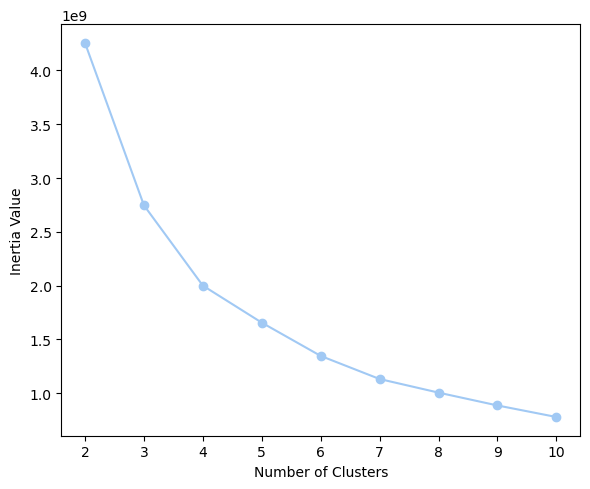

In [334]:
from sklearn.cluster import KMeans

df_kmean.set_index("Customer_id", inplace = True) ## convert 'id' column to index since KMeans cluster can only proceed numeric value

k = df_kmean.values # store the values into an array, these value will be used as input data for the K-Means model
n_cluster = range(2, 11, 1) # specify the range of clusters that will be evaluated by the Elbow method, ranging from 2 to 10 clusters 
inertia_value = [] # create an empty list to store the result of each cluster 

# create a 'for' loop to evaluate each cluster
for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=123)
    model.fit(k)
    inertia_value.append(model.inertia_) # The results of the fitted model is calculated and added to the 'inertia_value' list

# plot the results
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, inertia_value, marker="o")

ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia Value")

fig.tight_layout()

As shown in the line plot, the optimal number of clusters is 4.

In [335]:
## Create a K-Means model with 4 clusters and apply it to the dataset
n_cluster = 4

model = KMeans(n_clusters = n_cluster, random_state=123)
y = model.fit_predict(k)

df_kmean["Cluster"] = y
df_kmean.head()

,Recency,Frequency,Monetary,Cluster
Customer_id,,,,
2aa9325eab1676f4d62830f004d67a34,278,1,12.77,3
bb50112c998293f45f49f49704165768,526,1,18.90,0
ebf40c0db4fe06ddd15a7a44238c986e,141,2,197.35,3
56987d3e10c71d7d4e0fc479e65a35b6,69,1,246.90,3
3159faae98c743546432be5a500179a1,513,1,14.00,0


In [337]:
# sumarize each cluster
cluster_sum = df_kmean.groupby("Cluster").agg({"Recency": "mean", "Frequency": "mean", 
                                               "Monetary":"mean"})
cluster_sum["Cluster Size"] = df_kmean.groupby("Cluster").size()
cluster_sum

,Recency,Frequency,Monetary,Cluster Size
Cluster,,,,
0,452.041828,1.025899,100.066356,37415
1,294.562168,1.120180,557.552518,6016
2,306.681638,1.091149,1764.874386,757
3,191.008169,1.031003,99.605767,50802


Summary of K-Means Result:

Cluster 2 is the group with the highest value of customers, while cluster 4 is the group with the lowest value. Cluster 1 refers to the most loyal customers, and cluster 3 represents the newest customers.

Corresponding to the segmentation results from the RFM analysis, 
    
    cluster 0 represents the "Low Value" segment with RFM values below average levels, 
    cluster 1 corresponds to the "Potential big spenders" segment with high F and M, but inactive recently, 
    cluster 2 stands for the "Need Attention" segment with the highest M, but low F and inactive recently,
    cluster 3 is the "Promising" segment, consisting of the most recent customers who spent less. 

/Users/wenzhishan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wenzhishan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wenzhishan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

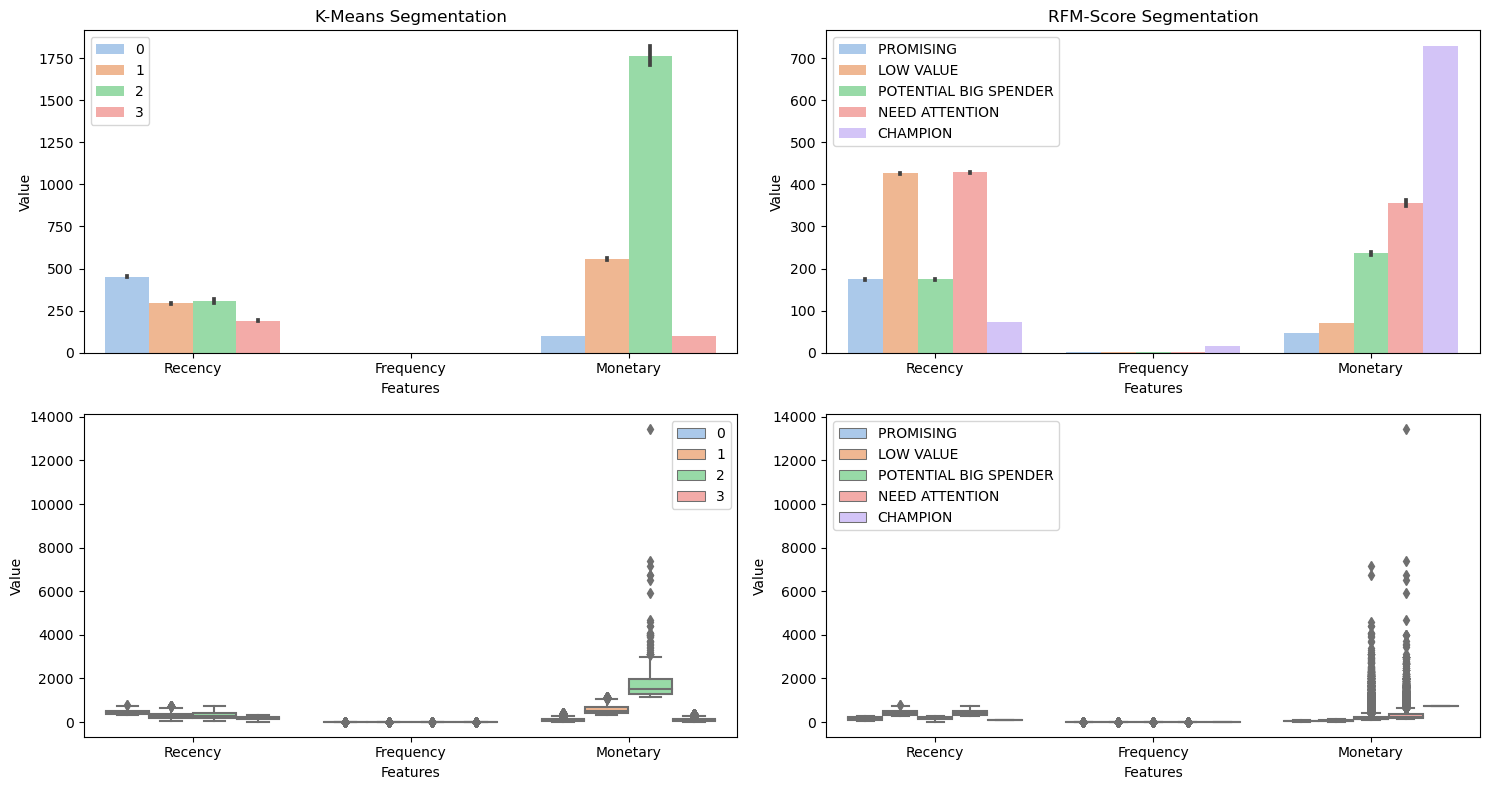

In [338]:
# create bar charts to compare two different segmentations
fig, axes = plt.subplots(figsize=(15, 8), nrows = 2, ncols = 2)
sns.set_palette("pastel")
# K-Means Segmentation
plot_cluster = pd.melt(df_kmean.reset_index(),
                       id_vars = ["Customer_id", "Cluster"],
                       value_vars = ["Recency", "Frequency", "Monetary"],
                       var_name = "Features",
                       value_name = "Value")
# 
sns.barplot('Features', "Value", hue = "Cluster", data = plot_cluster, ax = axes[0,0])
axes[0,0].set_ylabel("Value")
axes[0,0].set_title("K-Means Segmentation")
axes[0,0].legend()

sns.boxplot('Features', "Value", hue = "Cluster", data = plot_cluster, ax = axes[1,0])
axes[1,0].set_ylabel("Value")
axes[1,0].legend()

#RFM-Score Segmentation
plot_segment = pd.melt(df_rfm.reset_index(),
                       id_vars = ["Customer_id", "Segment"],
                       value_vars = ["Recency", "Frequency", "Monetary"],
                       var_name = "Features",
                       value_name = "Value")

sns.barplot('Features', "Value", hue = "Segment", data = plot_segment, ax = axes[0,1])
axes[0,1].set_ylabel("Value")
axes[0,1].set_title("RFM-Score Segmentation")
axes[0,1].legend()

sns.boxplot('Features', "Value", hue = "Segment", data = plot_segment, ax = axes[1,1])
axes[1,1].set_ylabel("Value")
axes[1,1].legend()


plt.tight_layout()
plt.show()

## Conclusion

By comparing two segmentation methods, I think RFM segmentation outperforms K-Means. 

 - K-Means Limitations:
   - Overlook loyal customers
   
     - While K-Means works better in distinguishing between different groups, as indicated by the larger differences observed in the boxplot, it fails to capture some of the crucial insights. For example, the average frequency across all four clusters is approximately "1", which might give the impression that there are no loyal customers at all. This reflects the K-Means Algorithm's trade-off: it maximizes variance among clusters yet overlooks the business context and relies solely on mathematical patterns in the data.
      
   - Overlooking inactivity variation among Big Spenders
   
      - Clusters 1 and 2 are both big spenders who have remained inactive for around 10 months(300 days). The only distinction between them is monetary. While this could be beneficial for tailoring customer rewards based on spending levels, it overlooks the variation between those made recent purchases versus those have been inactive for a long period. 
     
         (*The recency of "Potential big spenders" in RFM is 174 days (6 months), much less than the average level(300 days). Recent buyers could benefit from product recommendations based on their recent purchases. In contrast, for dormant customers, who might have lost interest in their previous purchases, reactivation efforts would be better focused on sending them the most appealing offers or incentives.*)   
         
     In this context, RFM segmentation proves more advantageous than K-Means, as it separates customers into "Potential big spenders" and "Need Attention" segments.
   

 - RFM Segmentation Limitations: 
   - Bias in Percentile Method Classification
     - The assignment of RFM scores relies on percentiles, which potentially leading to less convincing outcomes due to variances within each segment. 
         Furthermore, the outcomes might not align well with a typical e-commerce business given the nature of the original data. For instance, customers classified as inactive have recency values around or below the average recency (300 days - 10 months) in this analysis, whereas the standard for inactivity in most e-commerce businesses usually falls within the range of 30-60 days (1-2 months). 